In [1]:
# Required Installations
# !pip install scikit-learn
# !pip install ipywidgets

# Imported Modules

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import re
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Loading the Data in csv format

In [3]:
df = pd.read_csv("Student_pred.csv")

In [4]:
df.head()

,Department,Gender,HSC,SSC,Income,Hometown,Computer,Preparation,Gaming,Attendance,Job,English,Extra,Semester,Last,Overall
0,Business Administration,Male,4.17,4.84,"Low (Below 15,000)",Village,3,More than 3 Hours,0-1 Hour,80%-100%,No,3,Yes,6th,3.220,3.350
1,Business Administration,Female,4.92,5.00,"Upper middle (30,000-50,000)",City,3,0-1 Hour,0-1 Hour,80%-100%,No,3,Yes,7th,3.467,3.467
2,Business Administration,Male,5.00,4.83,"Lower middle (15,000-30,000)",Village,3,0-1 Hour,More than 3 Hours,80%-100%,No,4,Yes,3rd,4.000,3.720
3,Business Administration,Male,4.00,4.50,"High (Above 50,000)",City,5,More than 3 Hours,More than 3 Hours,80%-100%,No,5,Yes,4th,3.800,3.750
4,Business Administration,Female,2.19,3.17,"Lower middle (15,000-30,000)",Village,3,0-1 Hour,2-3 Hours,80%-100%,No,3,Yes,4th,3.940,3.940


In [5]:
df.columns

Index(['Department', 'Gender', 'HSC', 'SSC', 'Income', 'Hometown', 'Computer',
       'Preparation', 'Gaming', 'Attendance', 'Job', 'English', 'Extra',
       'Semester', 'Last', 'Overall'],
      dtype='object')

In [6]:
df.shape

(493, 16)

# Data Preprocessing

# Step1: Drop Unnecessary Columns (Department, Job)

In [7]:
df_cleaned = df.drop(['Department', 'Job'], axis=1)
# df_cleaned.head()

# Step2: Clean and Convert 'Income' column to numeric values

In [8]:
# Clean income
def clean_income(income):
    income=str(income)
    if 'Below 15,000' in income:
        return 15000
    elif '15,000-30,000' in income:
        return 22500
    elif '30,000-50,000' in income:
        return 40000
    elif 'Above 50,000' in income:
        return 50000
    return None
df_cleaned['Income'] = df_cleaned['Income'].apply(clean_income)
# df_cleaned.head()

# Step3: Convert 'Playtime' into numeric averages (hours)

In [9]:
# Clean playtime
def clean_playtime(playtime):
    playtime=str(playtime)
    if '0-1 Hour' in playtime:
        return 0.5
    elif '1-2 Hours' in playtime:
        return 1.5
    elif '2-3 Hours' in playtime:
        return 2.5
    elif 'More than 3 Hours' in playtime:
        return 4
    return None

df_cleaned['Gaming'] = df_cleaned['Gaming'].apply(clean_playtime)
# df_cleaned.tail()

# Step 4: Filter out students in Semester 8 and above

In [10]:
# Ensure all values in 'Semester' column are strings
df_cleaned['Semester'] = df_cleaned['Semester'].astype(str)

# Extract numeric values from 'Semester' column and convert them to float
df_cleaned['Semester'] = df_cleaned['Semester'].str.extract(r'(\d+)').astype(float)

# Filter for students in semesters less than 8
df_cleaned = df_cleaned[df_cleaned['Semester'] < 8]

# df_cleaned.tail()

# Step5: Handle NaN values and Numeric Conversion

In [11]:
# Clean preparation
def clean_preparation(prep):
    prep = str(prep)
    if '0-1 Hour' in prep:
        return 0.5
    elif '1-2 Hours' in prep:
        return 1.5
    elif '2-3 Hours' in prep:
        return 2.5
    elif 'More than 3 Hours' in prep:
        return 4
    return None

df_cleaned['Preparation'] = df_cleaned['Preparation'].apply(clean_preparation)
# df_cleaned.tail(10)

 # Step6: Handling Attendance Column

In [12]:
def clean_attendance(attendance):
    attendance = str(attendance)
    match = re.findall(r'(\d+)%-(\d+)%', attendance)
    if match:
        low, high = map(int, match[0])
        return (low + high) / 2
    elif '80%-100%' in attendance:
        return 90
    elif 'Below 40%' in attendance:
        return 40
    return None

df_cleaned['Attendance'] = df_cleaned['Attendance'].apply(clean_attendance)
# df_cleaned.tail()

In [13]:
df_cleaned.head(9)

,Gender,HSC,SSC,Income,Hometown,Computer,Preparation,Gaming,Attendance,English,Extra,Semester,Last,Overall
0,Male,4.17,4.84,15000,Village,3,4.0,0.5,90.0,3,Yes,6.0,3.220,3.350
1,Female,4.92,5.00,40000,City,3,0.5,0.5,90.0,3,Yes,7.0,3.467,3.467
2,Male,5.00,4.83,22500,Village,3,0.5,4.0,90.0,4,Yes,3.0,4.000,3.720
3,Male,4.00,4.50,50000,City,5,4.0,4.0,90.0,5,Yes,4.0,3.800,3.750
4,Female,2.19,3.17,22500,Village,3,0.5,2.5,90.0,3,Yes,4.0,3.940,3.940
5,Male,4.75,4.05,22500,Village,3,0.5,4.0,40.0,4,No,2.0,1.000,1.000
6,Male,4.42,5.00,50000,Village,4,0.5,4.0,69.5,2,No,2.0,1.060,1.060
8,Male,3.32,4.50,15000,City,4,0.5,4.0,40.0,3,Yes,5.0,1.420,1.440
9,Female,3.33,4.95,22500,City,3,0.5,4.0,40.0,4,No,2.0,1.500,1.500


# Step7: Identify categorical columns

In [14]:
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns
categorical_cols

Index(['Gender', 'Hometown', 'Extra'], dtype='object')

In [15]:
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_cleaned[col] = le.fit_transform(df_cleaned[col])
    label_encoders[col] = le  # Store the encoder for future reference

In [16]:
df_cleaned.columns
# df_cleaned.head()

Index(['Gender', 'HSC', 'SSC', 'Income', 'Hometown', 'Computer', 'Preparation',
       'Gaming', 'Attendance', 'English', 'Extra', 'Semester', 'Last',
       'Overall'],
      dtype='object')

In [17]:
# Save the cleaned DataFrame as a CSV file
df_cleaned.to_csv('cleaned_data.csv', index=False)

from IPython.display import FileLink
# Display a link to download the CSV file
FileLink('cleaned_data.csv')


C:\Users\91739\cleaned_data.csv

<!-- # Features  -->

## Features

In [18]:
X = df_cleaned.drop(columns=['Last', 'Overall'], errors='ignore')
print(df_cleaned.columns)  # Verify column names
# X

Index(['Gender', 'HSC', 'SSC', 'Income', 'Hometown', 'Computer', 'Preparation',
       'Gaming', 'Attendance', 'English', 'Extra', 'Semester', 'Last',
       'Overall'],
      dtype='object')


## Target 

In [19]:
y = df_cleaned['Overall']  # Predicting overall CGPA
# y

## Train Test and Splitting the dataset at (80:20)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Fitting the model

In [21]:
# Create a polynomial regression model of degree 3
degree = 3
poly_reg_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
poly_reg_model.fit(X, y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('linearregression', LinearRegression())])

## Prediction

In [25]:
y_pred = poly_reg_model.predict(X_test)

In [26]:
print(f"Predicted values: {[f'{val:.2f}' for val in y_pred]}")

Predicted values: ['3.73', '3.04', '3.74', '1.49', '2.93', '3.71', '3.86', '3.30', '3.55', '2.87', '3.44', '3.15', '3.71', '3.21', '3.85', '3.24', '3.20', '3.26', '2.13', '0.96', '2.87', '3.42', '2.52', '3.94', '2.90', '3.74', '3.02', '3.09', '2.66', '2.51', '3.77', '3.59', '3.89', '3.41', '3.57', '3.43', '2.57', '2.19', '3.34', '3.26', '3.98', '2.35', '3.23', '3.47', '2.31', '3.84', '2.82', '3.74', '2.66', '1.77', '2.80', '2.80', '1.48', '2.81', '2.80', '4.00', '3.94', '3.37', '3.66', '2.72', '3.99', '3.72', '2.75', '3.15', '3.86', '3.32']


## Model Evaluation

In [27]:
# Mean Squared Error and R sqaured
mse=mean_squared_error(y_test, y_pred)
r2=r2_score(y_test,y_pred)
print("Mean Squared Error: ",mse)
print("R Squared error:",r2)

Mean Squared Error:  0.003516799738778285
R Squared error: 0.9917379483881485


Data Visualisation

In [38]:
# Generate correlation matrix
plt.figure(figsize=(10, 6))
correlation_matrix = df_cleaned.corr()

<Figure size 1000x600 with 0 Axes>

<Axes: >

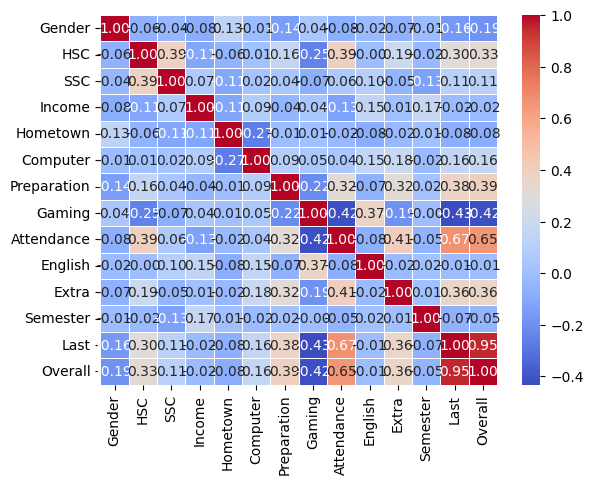

In [39]:
# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

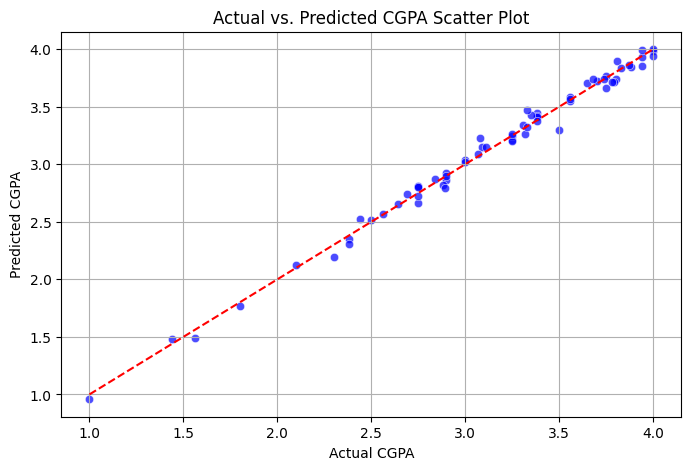

In [41]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, color="blue")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="--", color="red")
plt.xlabel("Actual CGPA")
plt.ylabel("Predicted CGPA")
plt.title("Actual vs. Predicted CGPA Scatter Plot")
plt.grid(True)
plt.show()

Model building with Decision Tree Regressor

In [42]:
from sklearn.tree import DecisionTreeRegressor

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
# Train a Decision Tree Regressor
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X, y)

DecisionTreeRegressor(random_state=42)

In [45]:
# Predict & evaluate
y_pred_tree = tree_reg.predict(X_test)

In [46]:
print(f"Predicted values: {[f'{val:.2f}' for val in y_pred_tree]}")

Predicted values: ['3.70', '3.00', '3.80', '1.56', '2.90', '3.65', '3.94', '3.50', '3.56', '2.90', '3.38', '3.09', '3.79', '3.25', '3.88', '3.25', '3.25', '3.25', '2.10', '1.00', '2.84', '3.38', '2.44', '3.94', '2.90', '3.68', '3.00', '3.07', '2.75', '2.50', '3.75', '3.56', '3.81', '3.38', '3.56', '3.35', '2.56', '2.30', '3.31', '3.32', '4.00', '2.38', '3.08', '3.33', '2.38', '3.83', '2.88', '3.74', '2.64', '1.80', '2.75', '2.89', '1.44', '2.75', '2.75', '4.00', '4.00', '3.38', '3.75', '2.75', '3.94', '3.78', '2.69', '3.11', '3.87', '3.33']


In [47]:
# Mean Squared Error and R sqaured
mse_tree = mean_squared_error(y_test, y_pred_tree)
r2_tree = r2_score(y_test, y_pred_tree)

In [48]:
print("Mean Squared Error: ",mse_tree)
print("R Squared error: ",r2_tree)

Mean Squared Error:  5.976218978947059e-33
R Squared error:  1.0


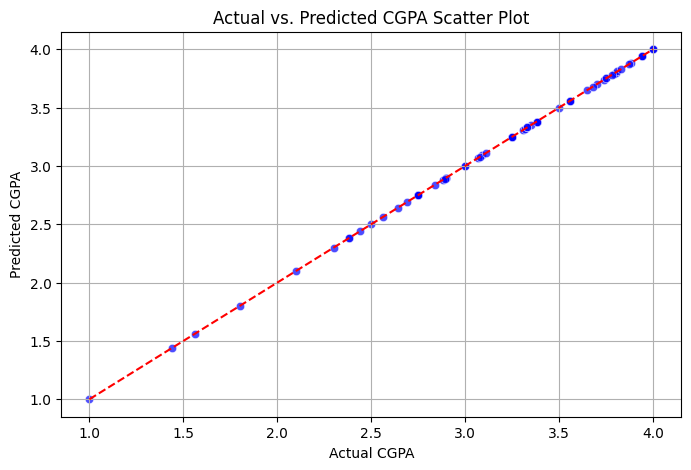

In [49]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred_tree, alpha=0.7, color="blue")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="--", color="red")
plt.xlabel("Actual CGPA")
plt.ylabel("Predicted CGPA")
plt.title("Actual vs. Predicted CGPA Scatter Plot")
plt.grid(True)
plt.show()